In [1]:
# Start with plotting settings, need to override my defaults
%matplotlib inline
import matplotlib
font = {'family' : 'Tahoma',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt


# load the relevant portions of the scientific python stack
from math import exp
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import loadmat

# Use the random package rather than numpy.random because it is much faster for single pulls and we cannot preallocate
# Profiling indicates that generating the random numbers is a pretty significant chunk of execution time
from random import randint, gauss, random as rand

# for simple profiling
import time

# Problem description

We have two layers traced in some radar data. We use the first (orange layer below) to infer an accumulation rate in space. This is assumed to be scalable in time but have a constant pattern. Similarly, we have velocities; these are also assumed to have a constant pattern but be scalable in time.

We want to figure out a history of velocity and accumulation to produce an isochrone that looks like the second layer (labeled 17 below), i.e. we want to find some scalings through time. We will use a simple model of vertical and horizontal velocities along with a Metropolis algorithm to do this.

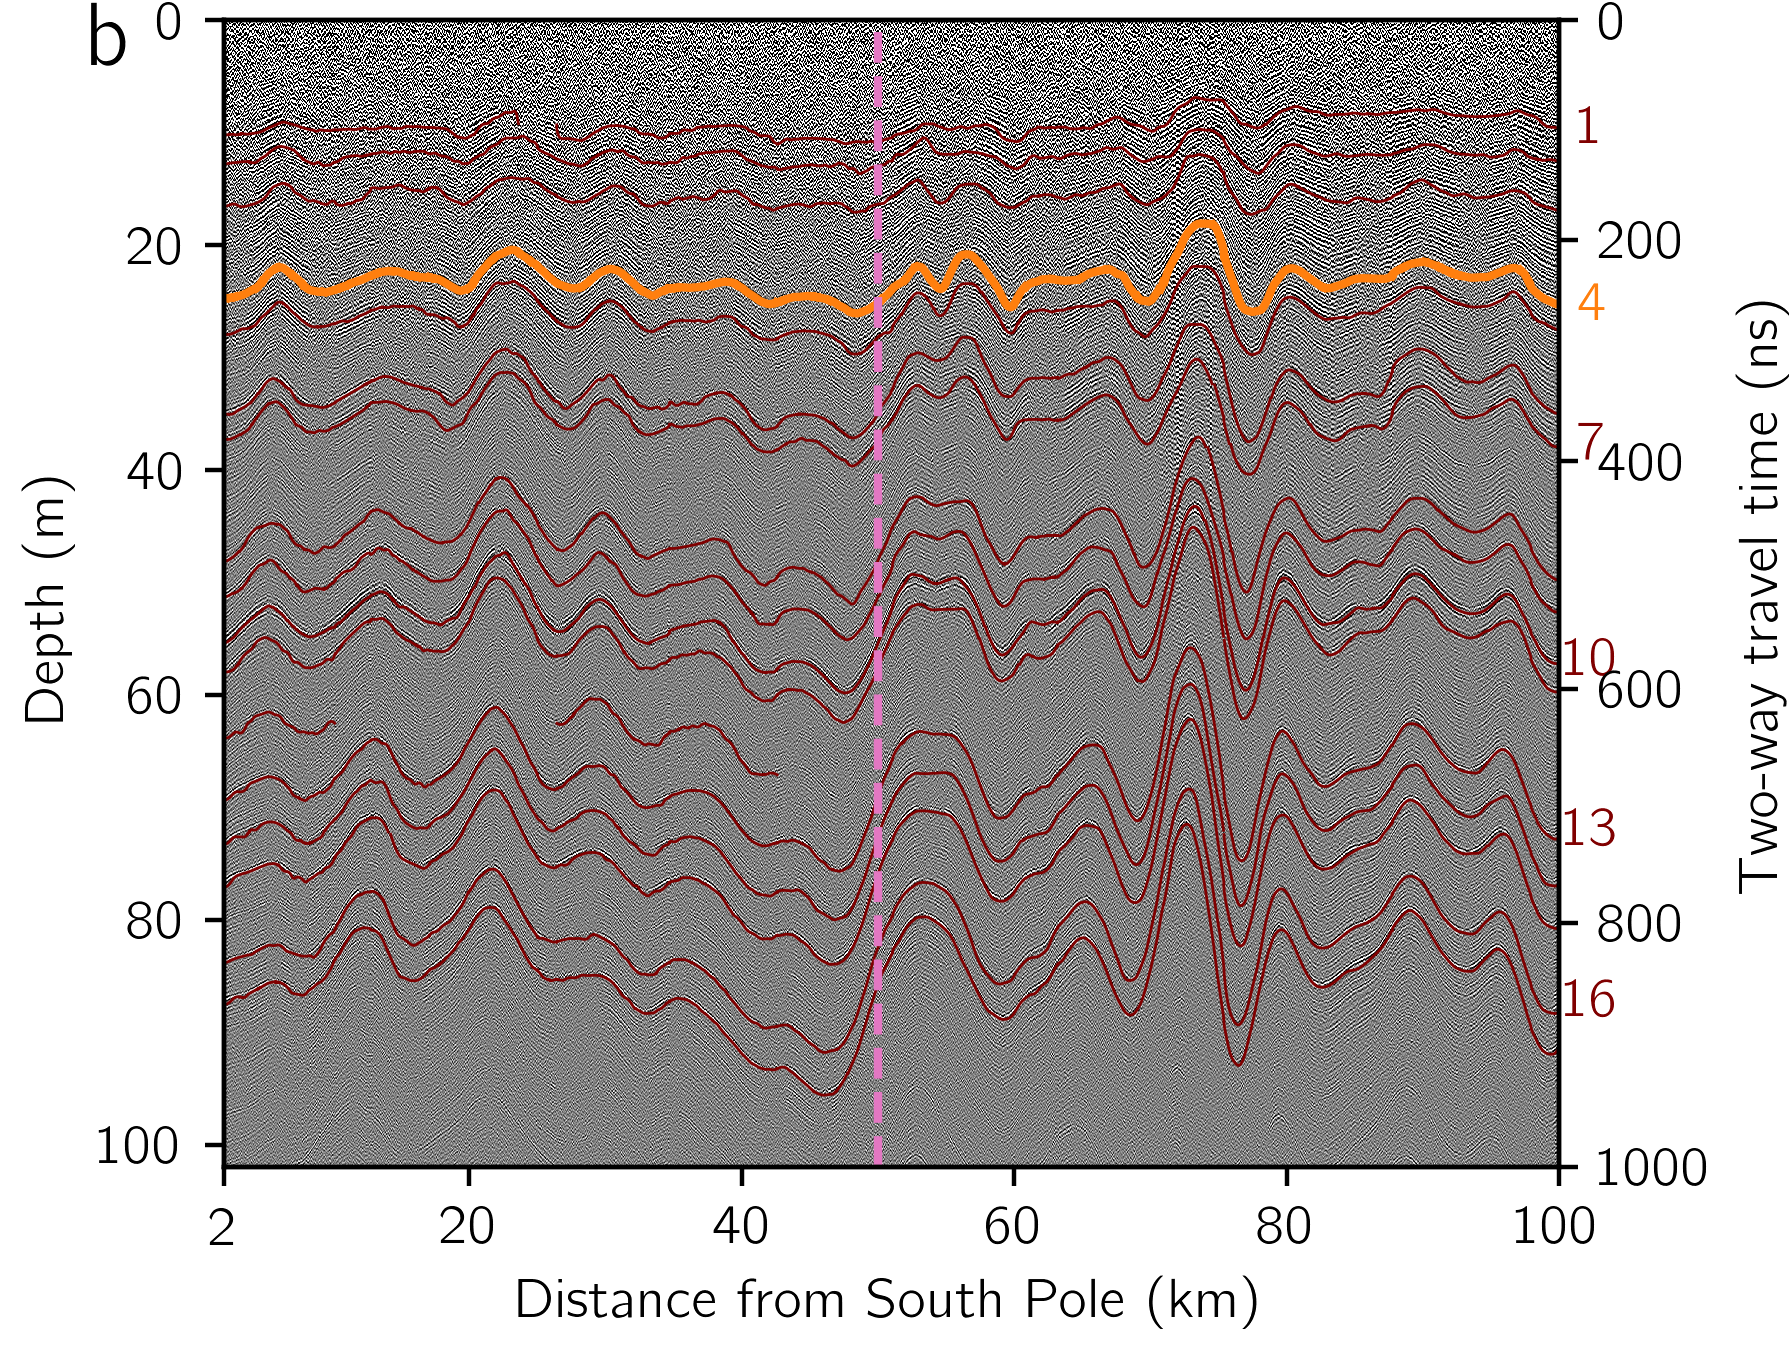

In [2]:
from IPython.display import Image
Image(filename='layers.png') 

## Load data
All the data are in some matlab files that we need to load. After loading, plot things up to be sure they are reasonable

In [3]:
layers = loadmat('layers.mat')
x = np.hstack(([0], np.cumsum(np.sqrt(np.diff(layers['psx_layers'][0]) ** 2.0 + np.diff(layers['psy_layers'][0]) ** 2.0))))
target_layer = layers['layer_14'][0]  # we want this as depth. is 725 years old

# These data are on other points. Interpolate so that they are relevant
more_data = loadmat('vels.mat')
vel_interpolater = interp1d(more_data['dists'][0], more_data['vels'][0])
vels = vel_interpolater(x)
acc_interpolater = interp1d(more_data['acc_dists'][0], more_data['acc'][0])
acc_rate = acc_interpolater(x) * 1.4  # need a little cheating to help us along

(0, 100000)

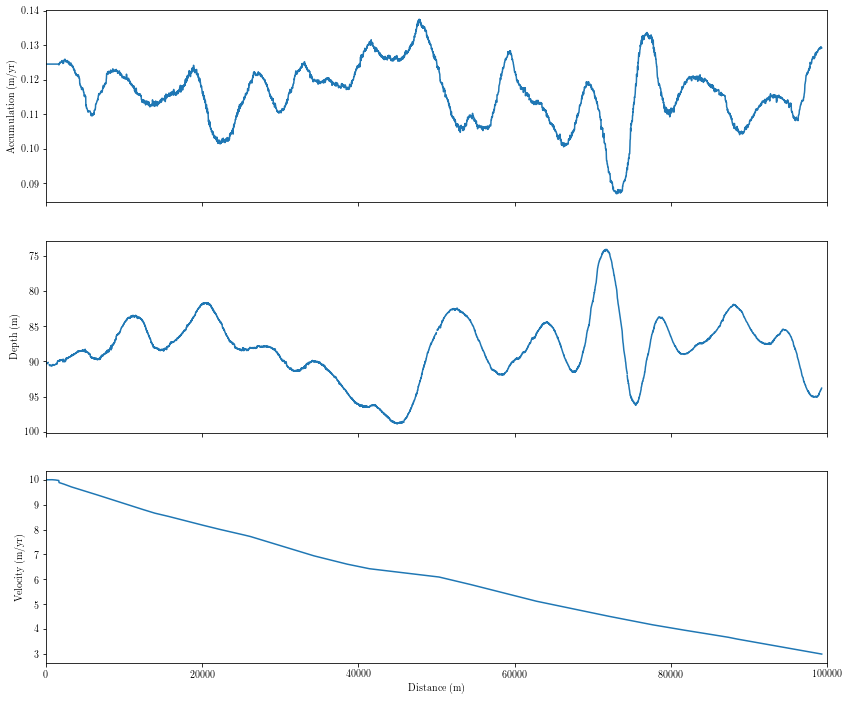

In [4]:
# Make a figure to check that our inputs all look reasonable
fig1, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 12), nrows=3, sharex=True)

ax1.plot(x, acc_rate)
ax1.set_ylabel('Accumulation (m/yr)')

ax2.plot(x, target_layer)
ax2.invert_yaxis()
ax2.set_ylabel('Depth (m)')

ax3.plot(x, vels)
ax3.set_ylabel('Velocity (m/yr)')

ax3.set_xlabel('Distance (m)')
ax1.set_xlim(0, 100000)

## Define the forward model
We want to take in accumulation (first panel above) and try to output a deep layer (second panel above) using simple functions of avertical velocity (assumed to be a function of the accumulation alone) and a scaled horizontal velocity (scaled from the third panel above).

In [5]:
def vz(acc_rate, z, kink_height=0.2, thickness=2700.):
    """Given vectors of accumulations at different horizontal positions and depths at those positions
    return a vector of vertical velocities. From Dansgaard-Johnsen 1969.
    
    Parameters
    ----------
    acc_rate: np.ndarray(n x 1)
        Accumulation rate at various points
    z: np.ndarray(n x 1)
        Depth at which to evaluate velocity corresponding to accumulation rate
    kink_height:
        Parameter used in Dansgaard-Johnsen model. Just leave it.
    thickness:
        Ice thickness. Just leave it.
        
    Returns
    -------
    vzs: np.ndarray(n x 1)
        Vertical velocity at each accumulation/depth pair
    """
    # DJ eq. 10
    return (2.0 * (1.0 - z / thickness) - kink_height) / (2.0 - kink_height) * acc_rate


def model(x, vx_and_acc_of_t, acc_rate, vx_of_x, total_time, n_tsteps=10):
    """This is our simple model.
    
    We take in a vx(t) and acc(t) then return the layer that is input offset by a vertical and horizontal change
    We have to set a bunch of things about the model to do this
    
    vx_and_acc_of_t is the thing we are fiddling with to minimize cost.
    DOFs is n_tsteps * 2 since have acc and vx at each
    
    Parameters
    ----------
    x: np.ndarray(n x 1)
        Horizontal points at which we are operating
    vx_and_acc_of_t: np.ndarray(2n_tsteps x 1)
        Our vector of variations in vx and acc to evaluate
    acc_rate: np.ndarray(n x 1)
        accumulation pattern as a function of x that gets scaled by the second half of vx_and_acc_of_t
    vx_of_x: np.ndarray(n x 1)
        Horizontal velocity as a funciton of x that gets scaled by the first half of vx_and_acc_of_t
    total_time: float
        How long the model runs for. This is the difference in layer ages.
    n_tsteps: int
        Number of points into which we should discretize total_time. Sets the total DOFs
        
    Returns
    -------
    z: np.ndarray(n x 1)
        Output layer depths at the points x
    """
    timestep_size = total_time / n_tsteps
    z = np.zeros_like(x)
    for step in range(n_tsteps):
        z = model_step(vx_and_acc_of_t[step], vx_and_acc_of_t[n_tsteps + step], vx_of_x, acc_rate, x, z, timestep_size=timestep_size)
    return z
        

def model_step(vx_current, acc_current, vx_of_x, acc_rate, x, z, timestep_size=150.):
    """This is the workhorse of our simple model
    
    It used a Dansgaard-Johnsen vertical velocity and a vertically uniform horizontal velocity to translate a layer.
    The horizontal velocity has a fixed horizontal profile that we just scale.
    It returns the layer, translated by velocities times the timestep.
    
    Parameters
    ----------
    vx_current: float
        Scale the x velocities by this much
    acc_current: float
        Scale the accumulation by this much
    vx_of_x: np.ndarray(n x 1)
        Horizontal velocity as a funciton of x that gets scaled by the first half of vx_and_acc_of_t
    acc_rate: np.ndarray(n x 1)
        accumulation pattern as a function of x that gets scaled by the second half of vx_and_acc_of_t
    x: np.ndarray(n x 1)
        Horizontal points at which we are operating
    z: np.ndarray(n x 1)
        Current layer depth
        
    Returns
    -------
    z_pert: np.ndarray(n x 1)
        New layer depth
    """
    # translate the positions
    new_layer_x = x - vx_of_x * vx_current * timestep_size
    new_layer_z = z + vz(acc_rate * acc_current, z) * timestep_size
    
    # we want the values back on the original points
    interpolator = interp1d(new_layer_x, new_layer_z, fill_value='extrapolate')
    return interpolator(x)

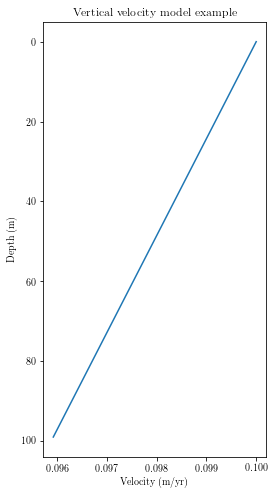

In [6]:
# First take a look at the vertical velocity model to be sure it works
# force it with a constant accumulation, look at velocity with depth
acc_test = np.ones((100,)) * 0.1
z_test = np.arange(0, 100)
vz_test = vz(acc_test, z_test)

# Plot it---it is linear as we expect
plt.figure(figsize=(4, 8))
plt.title('Vertical velocity model example')
plt.plot(vz_test, z_test)
plt.xlabel('Velocity (m/yr)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()

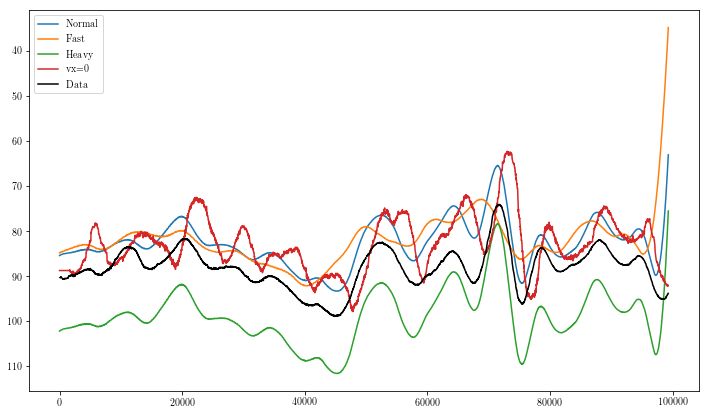

In [7]:
# Try the basic forward model
n_tsteps = 20
total_time = 725.
vx_and_acc_of_t = np.ones((2 * n_tsteps))

# also try some slightly modified versions
vx_and_acc_of_t_fast = np.ones((2 * n_tsteps))
vx_and_acc_of_t_fast[:n_tsteps] = 2.0
vx_and_acc_of_t_heavy = np.ones((2 * n_tsteps))
vx_and_acc_of_t_heavy[n_tsteps:] = 1.2
vx_and_acc_of_t_stationary = np.ones((2 * n_tsteps))
vx_and_acc_of_t_stationary[:n_tsteps] = 0.0

# run the model for each of the inputs
z = model(x, vx_and_acc_of_t, acc_rate, vels, total_time, n_tsteps=n_tsteps)
z_fast = model(x, vx_and_acc_of_t_fast, acc_rate, vels, total_time, n_tsteps=n_tsteps)
z_heavy = model(x, vx_and_acc_of_t_heavy, acc_rate, vels, total_time, n_tsteps=n_tsteps)
z_stationary = model(x, vx_and_acc_of_t_stationary, acc_rate, vels, total_time, n_tsteps=n_tsteps)

# Visualize results
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x, z, label='Normal')
ax.plot(x, z_fast, label='Fast')
ax.plot(x, z_heavy, label='Heavy')
ax.plot(x, z_stationary, label='vx=0')
ax.plot(x, target_layer, color='k', label='Data')
ax.invert_yaxis()
ax.legend(loc='best')
plt.show()

You may think that it is weird that the red curve is wiggly--this is an interpolation artifact. We never had x offsets, so the interpolation to new points didn't happen and we preserved noise. We could eliminate it with even very small horizontal velocities.

## Cost function
We have a forward model. We now need a way to measure how good our forward model is. Define a cost function that can evaluate this. Let's make it able to enforce smoothness!

In [8]:
def cost(modeled_layer, measured_layer, vx_and_acc_vector, regularization=0.0):
    """Return the cost function given the measured layer and our model output
    
    Parameters
    ----------
    modeled_layer: np.ndarray(n x 1)
        The model output
    measured_layer: np.ndarray(n x 1)
        The data
    regularization: float
        A scaling of the total variation to add to the misfit when determining the cost function.
        This will need to be tuned if used. Turn off by setting to zero.
        
    Returns
    cost_reg: float
        The misfit/objective function/cost function
    cost_unreg: float
        The misfit/objective function/cost function without regularization. Useful for comparing regularizations
    """
    # need to split the regulariztion into accumulation and velocity variations
    if regularization > 0:
        reg = np.nansum(np.diff(vx_and_acc_vector[:len(vx_and_acc_vector) // 2]) ** 2.0) + np.nansum(np.diff(vx_and_acc_vector[len(vx_and_acc_vector) // 2:]) ** 2.0)
    else:
        reg = 0.0
    unreg_cost = np.sqrt(np.nansum((modeled_layer - measured_layer) ** 2.0))
    return unreg_cost + regularization * reg, unreg_cost

In [9]:
# Test the cost function by measuring how good our models above are
for name, output, inputl in [('Normal', z, vx_and_acc_of_t),
                             ('Fast', z_fast, vx_and_acc_of_t_fast),
                             ('Heavy', z_heavy, vx_and_acc_of_t_heavy),
                             ('vx=0', z_stationary, vx_and_acc_of_t_stationary)]:
    print('For {:s} model, unregularized cost is {:f}'.format(name, cost(output, target_layer, inputl, regularization=0.0)[0]))
    print('Regularized cost is {:f}\n'.format(cost(output, target_layer, inputl, regularization=1.0)[0]))

For Normal model, unregularized cost is 432.134765
Regularized cost is 432.134765

For Fast model, unregularized cost is 605.484928
Regularized cost is 605.484928

For Heavy model, unregularized cost is 797.880177
Regularized cost is 797.880177

For vx=0 model, unregularized cost is 529.143947
Regularized cost is 529.143947



Cost function looks good unregularized, but we only had inputs with no variation. We want to see if the regularization actually worked, so let's do one with some lack of smoothness

In [10]:
# Do one more to check regularization
vx_and_acc_of_t_wiggly = np.ones((2 * n_tsteps))
vx_and_acc_of_t_wiggly[::2] = 1.5
z_wiggly = model(x, vx_and_acc_of_t_wiggly, acc_rate, vels, total_time, n_tsteps=n_tsteps)
for name, output, inputl in [('wiggly', z_wiggly, vx_and_acc_of_t_wiggly)]:
    print('For {:s} model, unregularized cost is {:f}'.format(name, cost(output, target_layer, inputl, regularization=0.0)[0]))
    print('Regularized cost is {:f}\n'.format(cost(output, target_layer, inputl, regularization=1.0)[0]))

For wiggly model, unregularized cost is 1082.884111
Regularized cost is 1092.384111



## Monte Carlo
We now have both a model and a way to determine if that model is good. It is time to set up the machinery to iteratively work towards a good solution.

In [11]:
n_tsteps = 20  # set our time resolution here so we can repeat it later
def monte_carlo_run(vx_and_acc_of_t,
                    total_time=725.,
                    n_tsteps=n_tsteps,
                    n_iterates=10 ** 4,
                    x=x,
                    acc_rate=acc_rate,
                    vels=vels,
                    target_layer=target_layer,
                    stepsize=0.1,
                    regularization=0.0):
    """Perform a suite of runs to get our distribution. We start with an initial guess, and move around.
    """
    # this is just to check how long it took
    now = time.time()
    
    # Preallocate locations for output--we want all our accepted models saved
    outputs = np.zeros((n_tsteps * 2, n_iterates))
    # misfits will have both a regularized and an unregularized row
    misfits = np.zeros((n_iterates, 2))
    
    # variable to increment--we use a while loop rather than a for loop since sometimes we dont step, and thus
    # we do no know how many times we will actually execute the loop
    i = 0
    
    # fencepost; this is so we don't have errors comparing to previous state
    z = model(x, vx_and_acc_of_t, acc_rate, vels, total_time, n_tsteps=n_tsteps)
    outputs[:, i] = vx_and_acc_of_t
    misfits[i] = cost(z, target_layer, vx_and_acc_of_t)

    # This is the real bulk of the work--keep trying to make steps downward
    while i < n_iterates - 1:
        # start by perturbing--first copy our vector to avoid modifying original in case we dont step
        vx_and_acc_of_t_pert = vx_and_acc_of_t.copy()
        # randint gives us a random component of the vector to perturb
        rand_ind = randint(0, n_tsteps * 2 - 1)
        # We use a normal distribution with variance "stepsize" for the perturbation    
        vx_and_acc_of_t_pert[rand_ind] = vx_and_acc_of_t[rand_ind] + gauss(0, stepsize)
        
        # enforce that both accumulation and velocity are strictly positive
        if vx_and_acc_of_t_pert[rand_ind] < 0:
            # if not positive, we don't save the perturbed state and we just restart this iteration of the while loop
            continue
    
        #evaluate model
        z = model(x, vx_and_acc_of_t_pert, acc_rate, vels, total_time, n_tsteps=n_tsteps)
    
        # see if model is any good---store cost function in vector, will be overwritten if not chosen
        misfits[i + 1, :] = cost(z, target_layer, vx_and_acc_of_t_pert, regularization=regularization)
        
        # Decide whether to accept our new guess
        if i < 1 or rand() < min(1, exp(-(misfits[i + 1, 0] - misfits[i, 0]))):
            # We have accepted the model! We need to store it, and save this state as the new model to step from
            outputs[:, i + 1] = vx_and_acc_of_t_pert
            vx_and_acc_of_t = vx_and_acc_of_t_pert.copy()
            
            # increment only upon acceptance of the guess
            i += 1

    print('Run took {:5.1f}s'.format(time.time() - now))
    return outputs, misfits

In [12]:
vx_and_acc_of_t = np.ones((2 * n_tsteps))
outputs, misfits = monte_carlo_run(vx_and_acc_of_t)

Run took  25.4s


Text(0,0.5,'Accumulation scale')

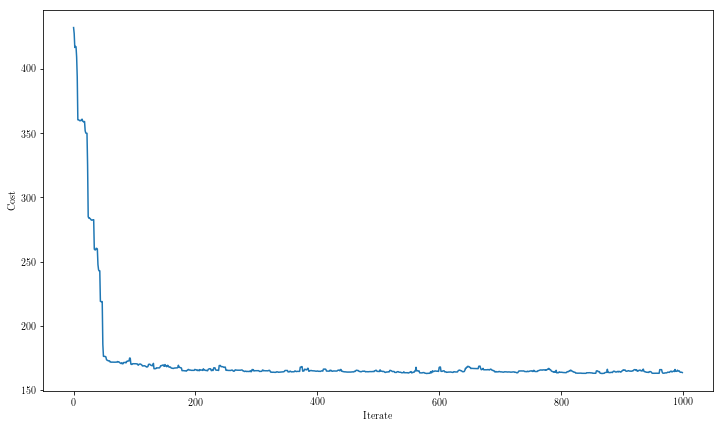

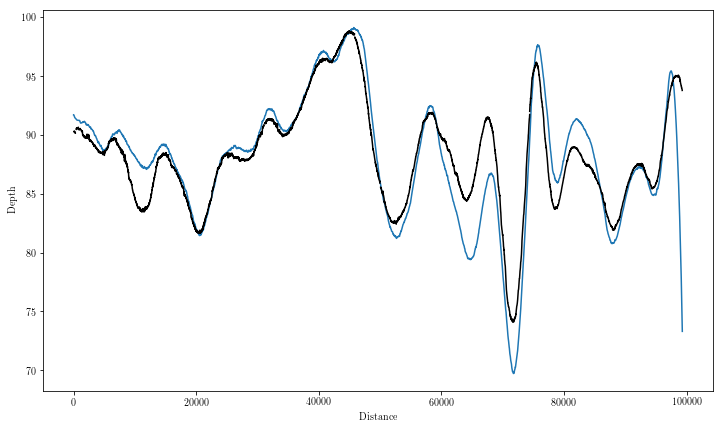

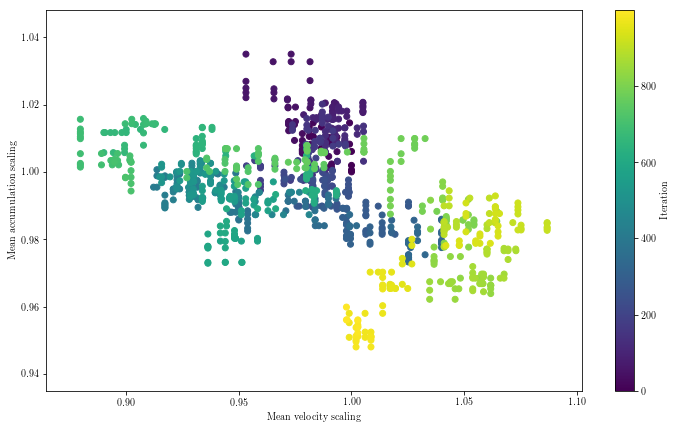

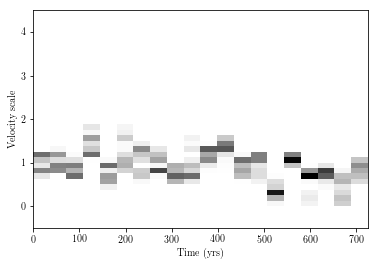

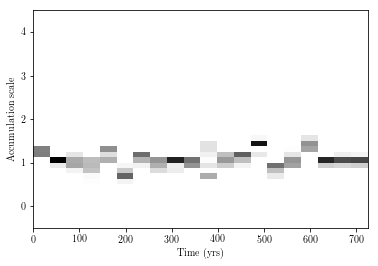

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(np.arange(misfits.shape[0]), misfits[:, 0])
ax.set_xlabel('Iterate')
ax.set_ylabel('Cost')

best = np.argmin(misfits[:, 0])
fig2, ax2 = plt.subplots(figsize=(12, 7))
z = model(x, outputs[:, best], acc_rate, vels, total_time, n_tsteps=n_tsteps)
ax2.plot(x, z)
ax2.plot(x, target_layer, color='k')
ax2.set_xlabel('Distance')
ax2.set_ylabel('Depth')

fig3, ax3 = plt.subplots(figsize=(12, 7))
vel_out = np.mean(outputs[:n_tsteps // 2], axis=0)
acc_out = np.mean(outputs[n_tsteps // 2:], axis=0)
cm = ax3.scatter(vel_out, acc_out, c=np.arange(len(vel_out)))
ax3.set_xlabel('Mean velocity scaling')
ax3.set_ylabel('Mean accumulation scaling')
plt.colorbar(cm, label='Iteration')

n_bins = 40
minv, maxv = -0.5, 4.5
cutoff = 170
histogram_edges = np.linspace(minv, maxv, n_bins + 1)
histogram = np.zeros((n_bins, n_tsteps))
he = np.zeros((n_bins + 1, n_tsteps))
good_mask = misfits[:, 0] < cutoff
for j in range(n_tsteps):
    histogram[:, j], he[:, j] = np.histogram(outputs[j, good_mask], bins=histogram_edges)
plt.figure()
plt.imshow(np.flipud(histogram), aspect='auto', cmap='Greys', extent=(0, total_time, minv, maxv), vmin=0, vmax=np.nanmax(histogram))
plt.xlabel('Time (yrs)')
plt.ylabel('Velocity scale')


histogram_edges = np.linspace(minv, maxv, n_bins + 1)
histogram = np.zeros((n_bins, n_tsteps))
he = np.zeros((n_bins + 1, n_tsteps))
good_mask = misfits[:, 0] < cutoff
for j in range(n_tsteps):
    histogram[:, j], he[:, j] = np.histogram(outputs[n_tsteps + j, good_mask], bins=histogram_edges)
plt.figure()
plt.imshow(np.flipud(histogram), aspect='auto', cmap='Greys', extent=(0, total_time, minv, maxv), vmin=0, vmax=np.nanmax(histogram))
plt.xlabel('Time (yrs)')
plt.ylabel('Accumulation scale')

## How good is this solution?

Let's rerun from different starting points and see if we get the same answer

Run took  25.7s
Run took  34.8s
Run took  25.6s


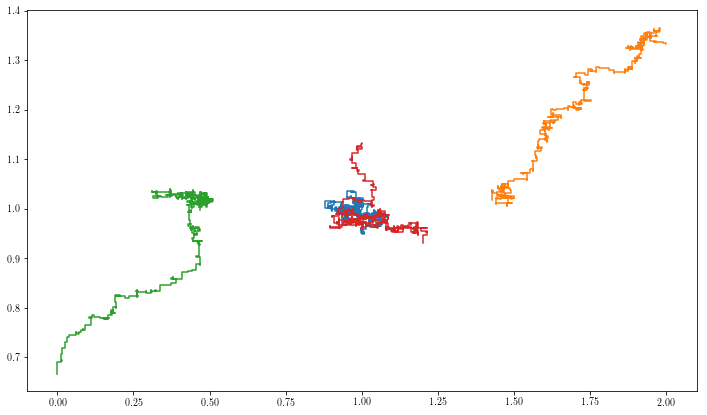

In [15]:
fig3, ax3 = plt.subplots(figsize=(12, 7))
vel_out = np.mean(outputs[:n_tsteps // 2], axis=0)
acc_out = np.mean(outputs[n_tsteps // 2:], axis=0)
ax3.plot(vel_out, acc_out)

vx_and_acc_of_t = np.ones((2 * n_tsteps))
vx_and_acc_of_t_fast = np.ones((2 * n_tsteps))
vx_and_acc_of_t_fast[:n_tsteps] = 2.0
vx_and_acc_of_t_heavy = np.ones((2 * n_tsteps))
vx_and_acc_of_t_heavy[n_tsteps:] = 1.2
vx_and_acc_of_t_stationary = np.ones((2 * n_tsteps))
vx_and_acc_of_t_stationary[:n_tsteps] = 0.0

vac_dict = {'fast': vx_and_acc_of_t_fast, 'stationary': vx_and_acc_of_t_stationary, 'heavy': vx_and_acc_of_t_heavy}
out_dict = {'normal': outputs}
misfit_dict = {'normal': misfits}

for name, vac in vac_dict.items():
    outputs, misfits = monte_carlo_run(vac)
    out_dict[name] = outputs
    misfit_dict[name] = misfits
    vel_out = np.mean(outputs[:n_tsteps // 2], axis=0)
    acc_out = np.mean(outputs[n_tsteps // 2:], axis=0)
    ax3.plot(vel_out, acc_out)

vac_dict['normal'] = vx_and_acc_of_t, 

(40, 4000)
(4000, 2)


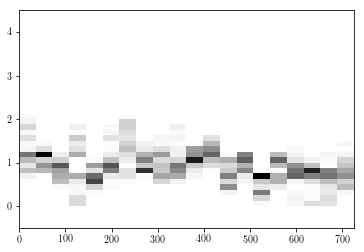

<Figure size 432x288 with 0 Axes>

In [18]:
# Lets try looking at the whole shebang
outs = np.hstack((out_dict.values()))
mis = np.vstack((misfit_dict.values()))

histogram_edges = np.linspace(minv, maxv, n_bins + 1)
histogram = np.zeros((n_bins, n_tsteps))
he = np.zeros((n_bins + 1, n_tsteps))
good_mask = mis[:, 0] < cutoff
for j in range(n_tsteps):
    histogram[:, j], he[:, j] = np.histogram(outs[j, good_mask], bins=histogram_edges)
histogram[histogram == 0] = np.nan
plt.figure()
plt.imshow(np.flipud(histogram), aspect='auto', cmap='Greys', extent=(0, total_time, minv, maxv), vmin=0, vmax=np.nanmax(histogram))

plt.figure()
for i in range(np.sum(good_mask) // 100):
    # plt.plot(outs[:, good_mask][:, i * 100])
    pass
plt.show()

In [22]:
outputs_smooth1, misfits_smooth1 = monte_carlo_run(vx_and_acc_of_t, regularization=1.0)
outputs_smooth01, misfits_smooth01 = monte_carlo_run(vx_and_acc_of_t, regularization=0.1)
outputs_smooth10, misfits_smooth10 = monte_carlo_run(vx_and_acc_of_t, regularization=10.0)
outputs_smooth100, misfits_smooth100 = monte_carlo_run(vx_and_acc_of_t, regularization=100.0)

Run took  25.2s
Run took  29.1s
Run took  34.7s
Run took  37.6s


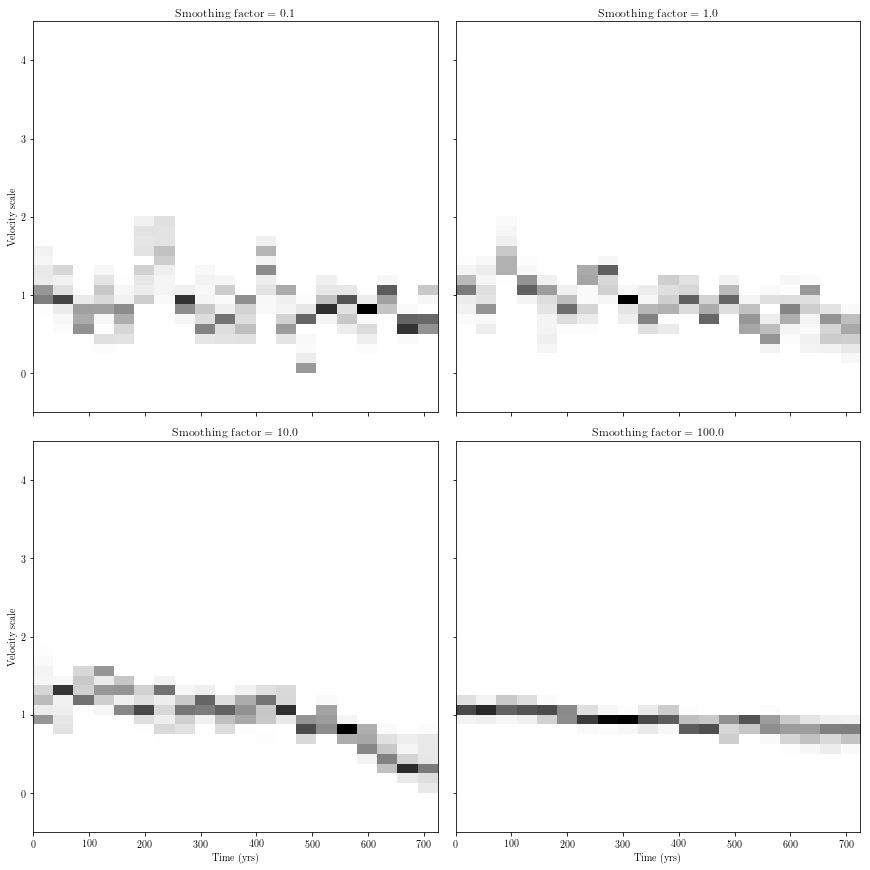

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), nrows=2, ncols=2, sharex=True, sharey=True)
for ax, name, outs, mis in [(ax1, 0.1, outputs_smooth01, misfits_smooth01),
                            (ax2, 1.0, outputs_smooth1, misfits_smooth1),
                            (ax3, 10.0, outputs_smooth10, misfits_smooth10),
                            (ax4, 100.0, outputs_smooth100, misfits_smooth100)]:
    histogram_edges = np.linspace(minv, maxv, n_bins + 1)
    histogram = np.zeros((n_bins, n_tsteps))
    he = np.zeros((n_bins + 1, n_tsteps))
    good_mask = mis[:, 1] < cutoff
    for j in range(n_tsteps):
        histogram[:, j], he[:, j] = np.histogram(outs[j, good_mask], bins=histogram_edges)
    histogram[histogram == 0] = np.nan
    ax.imshow(np.flipud(histogram), aspect='auto', cmap='Greys', extent=(0, total_time, minv, maxv), vmin=0, vmax=np.nanmax(histogram))
    ax.set_title('Smoothing factor = {:4.1f}'.format(name))
plt.tight_layout()
for ax in (ax3, ax4):
    ax.set_xlabel('Time (yrs)')
for ax in (ax1, ax3):
    ax.set_ylabel('Velocity scale')